셀프 주유소가 정말 저렴한지

In [1]:
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib
# Colab 런타임 다시 시작

In [18]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#폰트
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'NanumBarunGothic'

In [3]:
df=pd.read_csv('서울_주유소(220503).csv')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


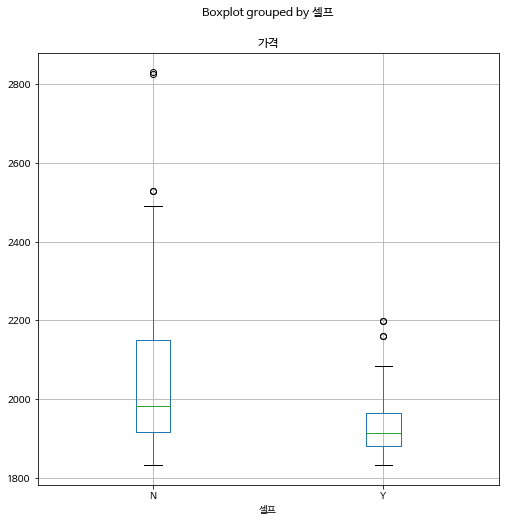

In [4]:
df.boxplot(column='가격',by='셀프',figsize=(8,8))
plt.show()

In [5]:
df[df.셀프=='Y'].가격.mean(), df[df.셀프=='N'].가격.mean()

(1927.0481927710844, 2059.4725738396623)

In [6]:
df[df.셀프=='Y'].shape, df[df.셀프=='N'].가격.shape

((249, 6), (237,))

* 사이파이를 이용한 가설 검정
 - 2 sample T 검정(독립표본 T검정 : T-test)

In [7]:
import scipy as sp
sp.stats.ttest_ind(df[df.셀프=='Y'].가격,df[df.셀프=='N'].가격,equal_var=False)

Ttest_indResult(statistic=-9.922706100747883, pvalue=4.663782062464101e-20)

p-value가 0.05보다 작으므로 귀무가설 기각, 즉 대립가설 채택 
* H0 (귀무가설) : 셀프 주유소와 일반 주유소의 가격 차이가 없다
* H1 (대립가설) : 셀프 주유소와 일반 주유소의 가격 차이가 있다 

p-value가 1에 가까울수록 두 그래프가 비슷하다..?

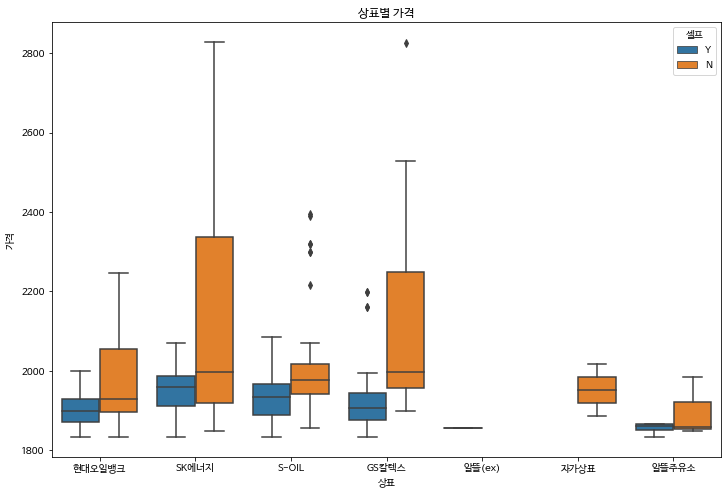

In [8]:
plt.figure(figsize=(12,8))
sns.boxplot(x='상표',y='가격',hue='셀프',data=df) #셀프를 반영한 값이 나옴
plt.title('상표별 가격')
plt.show()

4. 구별 휘발유 가격비교

In [10]:
import json,folium

In [11]:
#가격이 싼 주유소 top5
df.sort_values(by='가격').head()

,상호,주소,가격,셀프,상표,구
246,(주)대청에너지 대청주유소,서울 영등포구 가마산로 328 (대림동),1833,Y,GS칼텍스,영등포구
247,남서울고속주유소,서울 영등포구 가마산로 367 (대림동),1833,Y,SK에너지,영등포구
248,도림주유소,서울 영등포구 도림로 343 (도림동),1833,Y,알뜰주유소,영등포구
249,성락주유소,서울 영등포구 가마산로 414 (신길동),1833,Y,S-OIL,영등포구
250,(주)강서오일,서울 영등포구 도신로 151,1833,N,현대오일뱅크,영등포구


In [12]:
#가격이 비싼 주유소 top5
df.sort_values(by='가격',ascending=False).head()

,상호,주소,가격,셀프,상표,구
319,서남주유소,서울 중구 통일로 30,2829,N,SK에너지,중구
285,서계주유소,서울특별시 용산구 청파로 367 (청파동),2825,N,GS칼텍스,용산구
485,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2528,N,GS칼텍스,강남구
32,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2528,N,GS칼텍스,강남구
318,필동주유소,서울 중구 퇴계로 196 (필동2가),2489,N,GS칼텍스,중구


In [15]:
#구별 비교
df.groupby('구')['가격'].agg(['mean','min','max']).sort_values(by='mean',ascending=False).head()

,mean,min,max
구,,,
용산구,2345.538462,2117,2825
중구,2279.000000,1959,2829
종로구,2225.625000,1989,2485
강남구,2088.848485,1900,2528
강동구,2032.071429,1889,2298


* 구별 비교한 것을 단계구분도로 표시

In [17]:
gu_data = df.groupby('구')[['가격']].mean()
gu_data.head()

,가격
구,
강남구,2088.848485
강동구,2032.071429
강북구,1893.538462
강서구,1948.437500
관악구,1933.000000


In [19]:
filename='skorea_municipalities_geo_simple.json'
geo_str=json.load(open(filename),encoding='UTF-8')

In [20]:
import numpy as np

In [21]:
def get_text_location(geo_str):
  gu_dict={}
  for gu in geo_str['features']:
    for coord in gu['geometry']['coordinates']:
      geo=np.array(coord)
      gu_dict[gu['id']] = [np.mean(geo[:,1]),np.mean(geo[:,0])]
  return gu_dict

In [22]:
from folium.features import DivIcon

In [25]:
gu_dict=get_text_location(geo_str)

In [32]:
map=folium.Map(location=[37.5502, 126.982],zoom_start=11,tiles='Stamen Toner')
folium.Choropleth(    #단계구분도
    geo_data=geo_str,
    data=gu_data.가격,
    columns=[gu_data.index,gu_data.가격],
    fill_color='PuRd',
    key_on='feature.id'
).add_to(map)
for gu_name in gu_data.index:
  folium.Marker(
      location=gu_dict[gu_name],
      icon=DivIcon(icon_size=(80,20),icon_anchor=(20,0),
      html=f'<div style="font-size:10pt">{gu_name}</div>'
      )
  ).add_to(map)
title_html='<h3 align="center" style="font-size:20px">구별 주유소 가격</h3>'
map.get_root().html.add_child(folium.Element(title_html))
map